In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
# # print(tensorflow.__version__)
# import tensorflow as tf
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [2]:
file_path="model/facenet_keras.h5"
base_model=load_model(file_path)
print('Pretrained Model Summary')
print(base_model.summary())
print('No. of layers ', len(base_model.layers))

Pretrained Model Summary
Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
_______________________________________________________

Bottleneck (Dense)              (None, 128)          229376      Dropout[0][0]                    
__________________________________________________________________________________________________
Bottleneck_BatchNorm (BatchNorm (None, 128)          384         Bottleneck[0][0]                 
Total params: 22,808,144
Trainable params: 22,779,312
Non-trainable params: 28,832
__________________________________________________________________________________________________
None
No. of layers  426


In [3]:
for layer in base_model.layers:
    layer.trainable = False

In [4]:
x=base_model.layers[-5].output
x=GlobalAveragePooling2D()(x)
x=Dense(1024, activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024, activation='relu')(x) #dense layer 2
x=Dense(512,  activation='relu')(x) #dense layer 3
x=Dropout(0.25)(x)
preds=Dense(4, activation='softmax')(x) #final layer with softmax activation

model=Model(inputs=base_model.input,outputs=preds)
print(model.summary())
print('No. of layers ', len(model.layers))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_

In [6]:
# # Let's print our layers 
# for (i,layer) in enumerate(model.layers):
#     print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

In [7]:
# for layer in model.layers[:214]:
#     layer.trainable=False
# for layer in model.layers[214:]:
#     layer.trainable=True

In [5]:
# Let's print our layers 
for (i,layer) in enumerate(model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 BatchNormalization False
3 Activation False
4 Conv2D False
5 BatchNormalization False
6 Activation False
7 Conv2D False
8 BatchNormalization False
9 Activation False
10 MaxPooling2D False
11 Conv2D False
12 BatchNormalization False
13 Activation False
14 Conv2D False
15 BatchNormalization False
16 Activation False
17 Conv2D False
18 BatchNormalization False
19 Activation False
20 Conv2D False
21 BatchNormalization False
22 Activation False
23 Conv2D False
24 Conv2D False
25 BatchNormalization False
26 BatchNormalization False
27 Activation False
28 Activation False
29 Conv2D False
30 Conv2D False
31 Conv2D False
32 BatchNormalization False
33 BatchNormalization False
34 BatchNormalization False
35 Activation False
36 Activation False
37 Activation False
38 Concatenate False
39 Conv2D False
40 Lambda False
41 Activation False
42 Conv2D False
43 BatchNormalization False
44 Activation False
45 Conv2D False
46 Conv2D False
47 BatchNormalization False
48 

In [6]:
train_data_dir = 'facedata/train'
validation_data_dir = 'facedata/val'
batchSize=1000

imageSize=160
train_datagen=ImageDataGenerator( rescale=1./255,
                                  rotation_range=45,
                                  width_shift_range=0.3,
                                  height_shift_range=0.3,
                                  horizontal_flip=True,
                                  fill_mode='nearest'
                                ) 
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_directory(train_data_dir,
                                                  target_size=(imageSize,imageSize),
                                                  color_mode='rgb',
                                                  batch_size=batchSize,
                                                  class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(imageSize, imageSize),
        color_mode='rgb',
        batch_size=batchSize,
        class_mode='categorical')
   

Found 24 images belonging to 4 classes.
Found 14 images belonging to 4 classes.


In [7]:
# from keras.optimizers import RMSprop, SGD, Adam
# batch_size=32
import math

checkpoint = ModelCheckpoint("model/ajaymodel.h5",
                             monitor="val_acc",
                             mode='max',
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_acc', 
                          min_delta = 0, 
                          patience = 15,
                          verbose = 1,
                          mode='max'
                        )
# reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
#                               factor = 0.2,
#                               patience = 5,
#                               verbose = 1,
#                               min_delta = 0.0001)
callbacks = [earlystop, checkpoint]    

model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

nb_train_samples = 24
nb_validation_samples = 14
epochs = 20

step_size_train=int(math.ceil(1.0 * nb_train_samples / batchSize))
step_size_validation=int(math.ceil(1.0 * nb_train_samples / batchSize))

In [8]:
history = model.fit_generator(train_generator,
                    steps_per_epoch=step_size_train,
                    epochs=epochs,
                    callbacks = callbacks,
                    validation_data = validation_generator,
                    validation_steps = step_size_validation)

Epoch 1/20

Epoch 00001: val_acc improved from -inf to 0.71429, saving model to model/ajaymodel.h5
1/1 [==============================] - 42s 42s/step - loss: 1.4142 - acc: 0.2917 - val_loss: 0.9436 - val_acc: 0.7143
Epoch 2/20

Epoch 00002: val_acc did not improve from 0.71429
1/1 [==============================] - 1s 695ms/step - loss: 1.0484 - acc: 0.6667 - val_loss: 0.6057 - val_acc: 0.7143
Epoch 3/20

Epoch 00003: val_acc improved from 0.71429 to 0.85714, saving model to model/ajaymodel.h5
1/1 [==============================] - 1s 1s/step - loss: 0.7324 - acc: 0.7500 - val_loss: 0.3313 - val_acc: 0.8571
Epoch 4/20

Epoch 00004: val_acc improved from 0.85714 to 0.92857, saving model to model/ajaymodel.h5
1/1 [==============================] - 2s 2s/step - loss: 0.3896 - acc: 0.9583 - val_loss: 0.1785 - val_acc: 0.9286
Epoch 5/20

Epoch 00005: val_acc did not improve from 0.92857
1/1 [==============================] - 1s 568ms/step - loss: 0.4422 - acc: 0.8750 - val_loss: 0.1638 - v

In [ ]:
# x,y=model.evaluate()

In [ ]:
# validation_generator = validation_datagen.flow_from_directory(
#         validation_data_dir,
#         color_mode = 'rgb',
#         target_size=(imageSize, imageSize),
#         batch_size=batchSize,
#         class_mode='categorical',
#         shuffle=False)

# class_labels = validation_generator.class_indices
# class_labels = {v: k for k, v in class_labels.items()}
# classes = list(class_labels.values())
# print(class_labels)

Found 14 images belonging to 4 classes.
Confusion Matrix
[[5 0 0 0]
 [0 2 0 0]
 [0 0 4 0]
 [0 0 2 1]]
Classification Report
              precision    recall  f1-score   support

        Ajay       1.00      1.00      1.00         5
       Ajeet       1.00      1.00      1.00         2
 Aman pandey       0.67      1.00      0.80         4
        Amit       1.00      0.33      0.50         3

    accuracy                           0.86        14
   macro avg       0.92      0.83      0.82        14
weighted avg       0.90      0.86      0.84        14



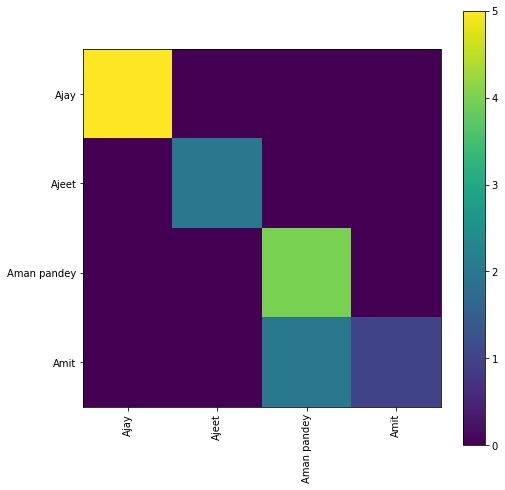

In [9]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# We need to recreate our validation generator with shuffle = false
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(imageSize, imageSize),
        batch_size=batchSize,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

nb_train_samples = 24
nb_validation_samples = 14

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, step_size_validation)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

In [ ]:
# from tensorflow.keras.models import load_model

# classifier = load_model('model/12_facenet_keras.h5')

In [ ]:
# classifier.predict(`)

In [ ]:
# from tensorflow.keras.models import load_model
# from tensorflow.keras.preprocessing import image
# import numpy as np
# import os
# import cv2
# import numpy as np
# from os import listdir
# from os.path import isfile, join
# import re

# def draw_test(name, pred, im, true_label):
#     BLACK = [0,0,0]
#     expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 300 ,cv2.BORDER_CONSTANT,value=BLACK)
#     cv2.putText(expanded_image, "predited - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
#     cv2.putText(expanded_image, "true - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
#     cv2.imshow(name, expanded_image)
    

# def getRandomImage(path, img_width, img_height):
#     """function loads a random images from a random folder in our test path """
#     folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
#     random_directory = np.random.randint(0,len(folders))
#     path_class = folders[random_directory]
#     file_path = path + path_class
#     file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
#     random_file_index = np.random.randint(0,len(file_names))
#     image_name = file_names[random_file_index]
#     final_path = file_path + "/" + image_name
#     return image.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class

# # dimensions of our images
# img_width, img_height = 160, 160

# files = []
# predictions = []
# true_labels = []

# # predicting images
# for i in range(0, 10):
#     path = './faces/val/' 
#     img, final_path, true_label = getRandomImage(path, img_width, img_height)
#     files.append(final_path)
#     true_labels.append(true_label)
#     x = image.img_to_array(img)
#     x = x * 1./255
#     x = np.expand_dims(x, axis=0)
#     images = np.vstack([x])
#     classes = classifier.predict_classes(images, batch_size = 32)
#     predictions.append(classes)
    
# for i in range(0, len(files)):
#     image = cv2.imread((files[i]))
#     image = cv2.resize(image, None, fx=5, fy=5, interpolation = cv2.INTER_CUBIC)
#     draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])
#     cv2.waitKey(0)

# cv2.destroyAllWindows()